In [1]:
import numpy as np
import ssid
import quakeio
from ssid import modal, spec
from ssid.utilities import Config, extract_channels, list_files, print_modes, mode_statistics

### Data inputs

In [2]:
directory = "../CESMD/CE58658/"
# pattern = "sanlorenzo_28june2021.zip"
pattern = "*[sb][ae][nr][lk]*"

In [3]:
data_conf = Config()

# HAYWARD TRANSVERSE (CASE 1)
title = "Hayward Bridge Transverse Mode (In: Ch25, Out: Ch23)"
data_conf.inputs  = [25,2,7,18]
data_conf.outputs = [23,13,15,20]
# # HAYWARD LONGITUDINAL (CASE 2)
# title = "Hayward Bridge Longitudinal Mode (In: Ch3, Out: Ch12)"
# data_conf.inputs  = [3,6,17]
# data_conf.outputs = [12,14,19]

In [4]:
# Set Parameters
conf = Config()
conf.m  = 500
conf.prediction_horizon = 190
conf.nc = 190
conf.order  = 12
conf.a  = 0  
conf.b  = 0  
conf.l  = 10 
conf.g  = 3
conf.period_band = (0.2,1.6)
conf.damping = 0.06
conf.pseudo = True

../CESMD/CE58658/berkeley_04jan2018_72948801_ce58658p.zip
peak acceleration (cm/s/s): 39.371


/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/realize.py:200: RuntimeWarning: invalid value encountered in matmul
  Ryy = Yno@Yno.T/ns
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/realize.py:201: RuntimeWarning: invalid value encountered in matmul
  Ruu = Uno@Uno.T/ns
100%|█████████▉| 12300/12301 [00:52<00:00, 233.54it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.8646     0.08013    1.0        0.8864     0.8864   
      0.3709     0.01628    1.0        0.8513     0.8513   
      0.2547     0.0343     0.01828    0.7914     0.01447  
      0.2287     0.01566    1.0        0.9913     0.9913   
      0.1924     0.008437   1.0        0.9663     0.9663   
Mean Period(s): 0.3822593410388288
Standard Dev(s): 0.24847497024189644
../CESMD/CE58658/sanlorenzo_28june2021.zip
peak acceleration (cm/s/s): 126.113


100%|█████████▉| 6500/6501 [00:13<00:00, 496.78it/s]
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  (abs(Phi_final[j,i])/abs(Phi_final_hat[j,i])),
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  Pij = np.angle(Phi_final[j,i]/Phi_final_hat[j,i])
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:24: RuntimeWarning: invalid value encountered in scalar divide
  Pij = np.angle(Phi_final[j,i]/Phi_final_hat[j,i])
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  nu[i]    = (s22[i]-s11[i])/(2*s12[i])
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:77: RuntimeWarning: invalid value encountered in scalar multiply
  lam[0,i] = (s11[i]+s22[i])/2 + s

Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2518     0.06787    0.0        0.942      0.0      
      0.0711     0.001755   1.0        0.933      0.933    
      0.02797    0.0002532  1.0        0.9983     0.9983   
      0.02775    0.0001942  1.0        0.9998     0.9998   
Mean Period(s): 0.09466590557934193
Standard Dev(s): 0.09244381427065751


Text(0.5, 0.98, 'Hayward Bridge Transverse Mode (In: Ch25, Out: Ch23)')

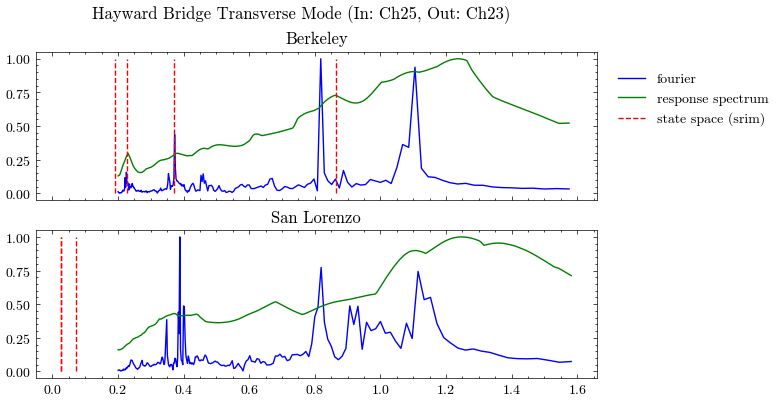

In [5]:
files = list(list_files(directory, pattern))
event_names = ["Berkeley", "San Lorenzo"]
# event_names = [str(file) for file in files]
event_modes = []
from matplotlib import pyplot as plt
file_axes = {}

fig, axs = plt.subplots(len(files), figsize=(6,2*len(files)), sharex=True, constrained_layout=True)
axi = iter(axs)

method = "srim"

for i, file in enumerate(files):
    ax = next(axi)
    # fig, ax = plt.subplots(figsize=(10,5))
    print(file)
    try:
        event = quakeio.read(file, exclusions=["*filter*", "*date*"])
        print("peak acceleration (cm/s/s):", event["peak_accel"])
        inputs, dt = extract_channels(event, data_conf["inputs"])
        outpts, dt = extract_channels(event, data_conf["outputs"])
        conf.decimation = 1 # decimation factor
        realization = ssid.system(method=method, inputs=inputs, outputs=outpts, threads=18, chunk=200, **conf)
    except Exception as e:
        # raise e
        print(e)
        continue
    ss_modes = modal.system_modes(realization,dt,conf.decimation,nt=inputs.shape[1])
    event_modes.append(list(ss_modes.values()))
    print_modes(ss_modes)
    conf.decimation = 1
    periods, amplitudes = spec.fourier_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, **conf)
    amplitudes = amplitudes/max(amplitudes)
    ax.plot(periods, amplitudes, label=["fourier" if i==0 else None][0], color="blue") #, alpha = (1/(len(files)+2))*(i+1))
    periods, amplitudes = spec.response_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, periods=periods, threads=8, **conf)
    amplitudes = amplitudes/max(amplitudes)
    ax.plot(periods, amplitudes, label=["response spectrum" if i==0 else None][0], color="green") #, alpha = (1/(len(files)+2))*(i+1))
    ax.vlines([1/value["freq"] for value in ss_modes.values() if value["energy_condensed_emaco"]>0.5 and value["mpc"]>0.5], 0, 1, color='r', linestyles='dashed', label=[f"state space ({method})" if i==0 else None][0])
    ax.set_title(event_names[i])
fig.legend(bbox_to_anchor=(1.3,0.85))
event_frequencies = mode_statistics(event_modes, "freq")
fig.suptitle(title)

../CESMD/CE58658/berkeley_04jan2018_72948801_ce58658p.zip
peak acceleration (cm/s/s): 39.371


100%|█████████▉| 12300/12301 [00:52<00:00, 234.38it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.8646     0.08013    1.0        0.8864     0.8864   
      0.3709     0.01628    1.0        0.8513     0.8513   
      0.2547     0.0343     0.01828    0.7914     0.01447  
      0.2287     0.01566    1.0        0.9913     0.9913   
      0.1924     0.008437   1.0        0.9663     0.9663   
Mean Period(s): 0.3822593410388288
Standard Dev(s): 0.24847497024189644
../CESMD/CE58658/sanlorenzo_28june2021.zip
peak acceleration (cm/s/s): 126.113


100%|█████████▉| 6500/6501 [00:14<00:00, 455.14it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2518     0.06787    0.0        0.942      0.0      
      0.0711     0.001755   1.0        0.933      0.933    
      0.02797    0.0002532  1.0        0.9983     0.9983   
      0.02775    0.0001942  1.0        0.9998     0.9998   
Mean Period(s): 0.09466590557934193
Standard Dev(s): 0.09244381427065751


Text(0.5, 0.98, 'Hayward Bridge Transverse Mode (In: Ch25, Out: Ch23)')

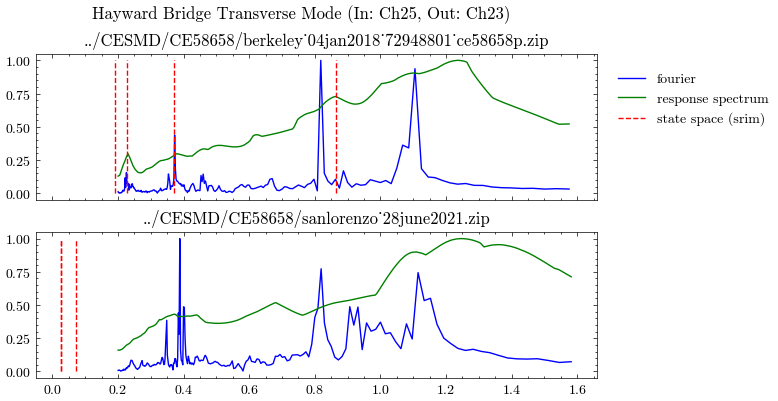

In [6]:
files = list(list_files(directory, pattern))
# event_names = ["Berkeley", "San Lorenzo"]
event_names = [str(file) for file in files]
event_modes = []
from matplotlib import pyplot as plt
file_axes = {}

fig, axs = plt.subplots(len(files), figsize=(6,2*len(files)), sharex=True, constrained_layout=True)
axi = iter(axs)

method = "srim"

for i, file in enumerate(files):
    ax = next(axi)
    # fig, ax = plt.subplots(figsize=(10,5))
    print(file)
    try:
        event = quakeio.read(file, exclusions=["*filter*", "*date*"])
        print("peak acceleration (cm/s/s):", event["peak_accel"])
        inputs, dt = extract_channels(event, data_conf["inputs"])
        outpts, dt = extract_channels(event, data_conf["outputs"])
        conf.decimation = 1 # decimation factor
        realization = ssid.system(method=method, inputs=inputs, outputs=outpts, **conf)
    except Exception as e:
        # raise e
        print(e)
        continue
    ss_modes = modal.system_modes(realization,dt,conf["decimation"],nt=inputs.shape[1])
    event_modes.append(list(ss_modes.values()))
    print_modes(ss_modes)
    conf.decimation = 1
    periods, amplitudes = spec.fourier_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, **conf)
    amplitudes = amplitudes/max(amplitudes)
    ax.plot(periods, amplitudes, label=["fourier" if i==0 else None][0], color="blue") #, alpha = (1/(len(files)+2))*(i+1))
    periods, amplitudes = spec.response_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, periods=periods, threads=8, **conf)
    amplitudes = amplitudes/max(amplitudes)
    ax.plot(periods, amplitudes, label=["response spectrum" if i==0 else None][0], color="green") #, alpha = (1/(len(files)+2))*(i+1))
    ax.vlines([1/value["freq"] for value in ss_modes.values() if value["energy_condensed_emaco"]>0.5 and value["mpc"]>0.5], 0, 1, color='r', linestyles='dashed', label=[f"state space ({method})" if i==0 else None][0])
    ax.set_title(event_names[i])
fig.legend(bbox_to_anchor=(1.3,0.85))
event_frequencies = mode_statistics(event_modes, "freq")
fig.suptitle(title)